In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn
import torch
from torch.utils.data import Dataset
from model_protein_vec import trans_basic_block, trans_basic_block_Config
from utils_search import *
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import pickle

from sklearn import svm
import faiss
import os # accessing directory structure
import pickle
import obonet
import pandas as pd
import numpy as np
import glob

/mnt/home/thamamsy/projects/protein_vec/lib/environment/protein_vec_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#Load the ProtTrans model and ProtTrans tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()
model = model.to(device)
model = model.eval()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
#################
####Change with the model path and config for each aspect

################# GO MFO
vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer4_GO_MFO_only_model/checkpoints/epoch=0-step=22704-val_loss=0.0233.ckpt'
vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer4_GO_MFO_only_model/params.json'

################## GO BPO
#vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer4_GO_BPO_only_model/checkpoints/epoch=0-step=21660-val_loss=0.0591.ckpt'
#vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer4_GO_BPO_only_model/params.json'

################## GO CCO
#vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer4_GO_CCO_only_model/checkpoints/epoch=0-step=27324-val_loss=0.0170.ckpt'
#vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer4_GO_CCO_only_model/params.json'

################## EC
#vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_EC4_only_model_with_margins_4_8_12_25/checkpoints/last.ckpt'
#vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_EC4_only_model_with_margins_4_8_12_25/params.json'

################## GENE3D
#vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_GENE3D_negative_mining/checkpoints/epoch=1-step=21960-val_loss=0.0021.ckpt'
#vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_GENE3D_negative_mining/params.json'

################## PFam
#vec_model_cpnt = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_PFAM_negative_mining/checkpoints/epoch=0-step=37100-val_loss=0.0016.ckpt'
#vec_model_config = '/mnt/home/thamamsy/ceph/protein_vec/models/model0.0001_dmodel1024_nlayer2_PFAM_negative_mining/params.json'


#Load the TM-Vec model
vec_model_config = trans_basic_block_Config.from_json(vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(vec_model_cpnt, config=vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

In [5]:
#Read in new proteins
meta_data_new = pd.read_csv('/mnt/home/thamamsy/ceph/protein_vec/data/uniprot_data/uniprotkb_AND_reviewed_true_2023_07_03.tsv', sep='\t')
lens = [len(meta_data_new['Sequence'].values[i]) for i in range(len(meta_data_new['Sequence'].values))]
meta_data_new['lens'] = lens

In [6]:
new_proteins = meta_data_new[meta_data_new['Date of creation'] > '2022-05-25'].reset_index(drop=True)
print('Number of new proteins deposited after 2022-05-25')
len(new_proteins)

Number of new proteins deposited after 2022-05-25


2350

In [7]:
flat_seqs = new_proteins['Sequence'].values
#Loop through the sequences and embed them
i = 0
embed_all_sequences = []
while i < len(flat_seqs): 
    protrans_sequence = featurize_prottrans(flat_seqs[i:i+1], model, tokenizer, device)
    embedded_sequence = embed_vec(protrans_sequence, model_deep, device)
    embed_all_sequences.append(embedded_sequence)
    i = i + 1
    
    if i % 200 == 0:
        print(i)

np_embed = np.concatenate(embed_all_sequences)

200
400
600
800
1000
1200
1400
1600
1800
2000
2200


In [10]:
#Perform TSNE
all_X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np_embed)
all_X_embedded_df = pd.DataFrame(all_X_embedded)
all_X_embedded_df.columns = ["Dim1", "Dim2"]

In [11]:
#Depending on the aspect the model is trained on, get meta data for the newly discovered proteins
all_X_embedded_df['Col']  = new_proteins['Gene Ontology (molecular function)'].values
#all_X_embedded_df['Col']  = new_proteins['Gene Ontology (biological process)'].values
#all_X_embedded_df['Col']  = new_proteins['Gene Ontology (cellular component)'].values
#all_X_embedded_df['Col']  = new_proteins['EC number'].values
#all_X_embedded_df['Col']  = new_proteins['EC number'].values
#all_X_embedded_df['Col']  = new_proteins['Gene3D'].values
#all_X_embedded_df['Col']  = new_proteins['Pfam'].values

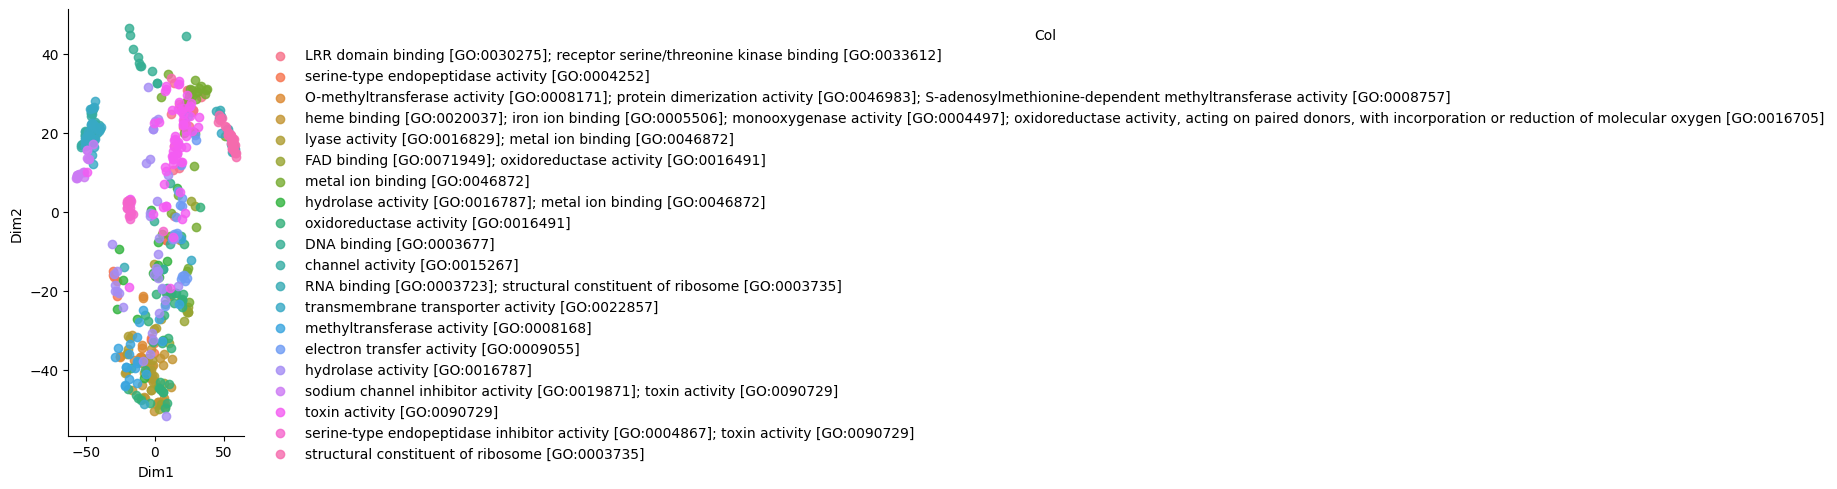

In [12]:
#For visualization purposes, get the top values before visualizing
tops = list(all_X_embedded_df['Col'].value_counts()[0:20].index)
sns.lmplot(x="Dim1", y="Dim2", data=all_X_embedded_df[all_X_embedded_df['Col'].isin(tops)], hue="Col", fit_reg=False)

In [69]:
############################
# Load in uniprot meta data
meta_data_new = pd.read_csv('/mnt/home/thamamsy/ceph/protein_vec/data/uniprot_data/uniprotkb_AND_reviewed_true_2023_07_03.tsv', sep='\t')
combined_outs = np.load('/mnt/home/thamamsy/projects/protein_vec/lib/protein_vec_mixture_of_experts/combined_training_proteins.npy', allow_pickle=True)
lookups = meta_data_new[meta_data_new['Entry'].isin(combined_outs)]

################## Load the metadata (for the lookup dataset), and then filter for only proteins from the training proteins 
lookup_proteins = np.load('/mnt/home/thamamsy/ceph/protein_vec/data/uniprot_data/training_splits/mmseq_splits/lookup_proteins.npy', allow_pickle=True)
lookup_proteins_meta = pd.DataFrame(lookup_proteins).reset_index()
lookup_proteins_meta = pd.merge(lookup_proteins_meta, lookups, left_on=0, right_on="Entry")

In [70]:
############################
# Load in the relevant embedding lookup database

load_path = '/mnt/home/thamamsy/ceph/protein_vec/embeddings/evaluation/aspects/all_mfo.npy'
#load_path = '/mnt/home/thamamsy/ceph/protein_vec/embeddings/evaluation/aspects/all_bpo.npy'
#load_path = '/mnt/home/thamamsy/ceph/protein_vec/embeddings/evaluation/aspects/all_cco.npy'
#load_path = '/mnt/home/thamamsy/ceph/protein_vec/embeddings/evaluation/aspects/all_ec.npy'
#load_path = '/mnt/home/thamamsy/ceph/protein_vec/embeddings/evaluation/aspects/all_gene3D.npy'
#load_path = '/mnt/home/thamamsy/ceph/protein_vec/embeddings/evaluation/aspects/all_pfam.npy'


In [71]:
############################ Specify the aspect

column = 'Gene Ontology (molecular function)' #'Gene Ontology (molecular function)' #'Gene Ontology (cellular component)' #'Gene Ontology (molecular function)' #'Gene Ontology (biological process)' #'Gene Ontology (biological process)' #'Gene3D' #'Pfam' #'EC number'
embeddings = np.load(load_path)

In [73]:
# Filter the lookup database for proteins with annotations

col_lookup = lookup_proteins_meta[~lookup_proteins_meta[column].isnull()]
col_lookup = col_lookup[~col_lookup[column].astype(str).str.contains('-', regex=False)]
col_lookup_embeddings = embeddings[col_lookup['index'].values]
col_meta_data = col_lookup[column].values

# Load the filtered lookup database
lookup_database = load_database(col_lookup_embeddings)

In [74]:
query_embeddings = np_embed

In [75]:
k = 1
D, I = query(lookup_database, query_embeddings, k)

In [76]:
#Get metadata for the nearest neighbors
near_ids = []
for i in range(I.shape[0]):
    meta = col_meta_data[I[i]]
    near_ids.append(list(meta))       

near_ids = np.array(near_ids)

In [77]:
col_meta_data = new_proteins[(~new_proteins[column].isnull()) & (~new_proteins[column].astype(str).str.contains('-', regex=False))]
rel_col = col_meta_data[column].values
relevant_indices = np.array(list(col_meta_data.index))
relevant_near_ids = near_ids[relevant_indices]

In [78]:
#this calculates the recall
intersection = []
for i in range(len(rel_col)):
    p1s = set(rel_col[i].split(";"))
    p2s = set(relevant_near_ids[i,0].split(";"))
    p1s = {item for item in p1s if item != ""}
    p2s = {item for item in p2s if item != ""}
    inter = len(list(p1s & p2s))
    acc = inter/len(p1s)
    intersection.append(acc)

In [79]:
print("New proteins, Gene Ontology (molecular function)")
print(np.mean(np.array(intersection)))
print(len(intersection))

New proteins, Gene Ontology (molecular function)
0.20557576425631982
1296
